In [28]:
#default_exp utils

In [82]:
#hide
from nbdev.showdoc import *
import numpy as np
from sklearn.metrics import pairwise_distances
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Graph Utilities: kernels, normalizations, and building diffusion matrices
At the heart of any good graph analysis is a good graph. This notebook provides tools for creating graphs from data, with support for all of the most advanced features, like sparse matrices, adaptive and anisotropic kernels, and more.

The algorithm for building a graph is simple:
1. Compute a distance matrix (with your choice of metric)
2. Apply a kernel to the distance matrix
3. Simplify the resulting affinity matrix by pruning connections below a certain threshold.

Then, on top of this, we can build a diffusion matrix by row-normalizing the resulting affinity matrix.

This entire system will be completely modular, allowing the user to swap in different kernel functions, distance functions, or diffusion calculations at will.

Each of the three main components will be defined seperately, and then incorporated into a parent function for convenience in later calling.

# Utils for the Utils

Everything here assumes sparse input, so we need a convenience function to turn everything sparse, even if it isn't initially.

In [83]:
# export
from scipy.sparse import bsr_array, csr_array
import warnings
def make_sparse_safe(A):
  if type(A) != 'scipy.sparse._arrays.bsr_array':
    warnings.warn("Sparsifying input to bsr_array")
    A = csr_array(A)
  return A

To preview what we'll be doing

In [84]:
A = np.random.rand(10,200)
type(A)

numpy.ndarray

In [85]:
sparse_A = bsr_array(np.random.rand(10,200))
type(sparse_A)

scipy.sparse._arrays.bsr_array

If we make a non sparse array "sparse safe", we should recieve a warning, but the conversion should be seamless -- and likewise if the input is a different type of sparse array

In [86]:
make_sparse_safe(A)

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


<10x200 sparse array of type '<class 'numpy.float64'>'
	with 2000 stored elements in Compressed Sparse Row format>

# Distance Matrix

To deal with potentially large datasets, everything will, by default, work with sparse matrices.
But, for compatibility, the functions will check whether the input is sparse, and if not, do the conversions for the user.

In [87]:
#export
from sklearn.metrics import pairwise_distances
def distance_matrix(X, metric = "euclidean"):
  X = make_sparse_safe(X) # converts to csr_array
  D = pairwise_distances(X, metric = metric, n_jobs = -1) # use all of the available cores
  return D


Does this work as expected?

In [88]:
X_sample = np.random.rand(100,100)
D_sample = distance_matrix(X_sample)
D_sample

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


array([[0.        , 3.94249335, 3.81670146, ..., 3.79196969, 3.66652175,
        4.06673077],
       [3.94249335, 0.        , 3.88599213, ..., 4.16741244, 3.86940003,
        4.24819379],
       [3.81670146, 3.88599213, 0.        , ..., 4.17855425, 4.13818745,
        3.77324563],
       ...,
       [3.79196969, 4.16741244, 4.17855425, ..., 0.        , 3.91507494,
        3.94174538],
       [3.66652175, 3.86940003, 4.13818745, ..., 3.91507494, 0.        ,
        4.14499727],
       [4.06673077, 4.24819379, 3.77324563, ..., 3.94174538, 4.14499727,
        0.        ]])

Apparently, even with sparse input, the pairwise distance function returns an nd_array. I suppose there's no point in sparsifying the distance matrix, as there are no nonzero rows -- though if memory was an issue, we could rewrite this to exploit the symmetry of the distance matrix.

In [89]:
X_sparse_sample = csr_array(X_sample)
D_sparse_sample = distance_matrix(X_sparse_sample)
type(D_sparse_sample)

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


numpy.ndarray

# Kernel
Now for the part with the most variation: the kernel.

We've built diffusion curvature to use either an "anisotropic" or "adaptive anisotropic" kernel. Given the distance matrix, it computes an adaptive kernel fitted to the k-neighborhood of each point. This is then normalized by density, following [CoifmanDiffusionMaps](x-devonthink-item://87C31C2B-8278-44D5-B011-EF65320C0B17):

$$ D^{-\alpha} A D^{-\alpha} $$

We've found $\alpha = 1$ to work well for our purposes.

In [90]:
#export
def anisotropic_kernel(D, sigma=0.7, alpha = 1):
  """Computes anisotropic kernel of given distances matrix.

  Parameters
  ----------
  D : ndarray or sparse
  sigma : float, optional
      Kernel bandwidth, by default 0.7
  alpha : int, optional
      Degree of density normalization, from 0 to 1; by default 1
  This is a good function.
  """
  W = np.exp(-D**2/(2*sigma**2))
  # Additional normalization step for density
  D = np.diag(1/(np.sum(W,axis=1)**alpha)) 
  W = D @ W @ D
  return W

In [91]:
#export
def adaptive_anisotropic_kernel(D, k=10, alpha = 1):
  # Get the distance to the kth neighbor
  distance_to_k_neighbor = np.partition(D,k)[:,k]
  # Populate matrices with this distance for easy division. 
  div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
  div2 = div1.T
  # compute the gaussian kernel with an adaptive bandwidth
  W = (1/2*np.sqrt(2*np.pi))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
  # Additional normalization step for density
  D = np.diag(1/(np.sum(W,axis=1)**alpha)) 
  W = D @ W @ D
  return W

The only tricky thing about this computation is obtaining the list of distances to the k-nearest neighbor. The standard function, `np.partition`, isn't defined for sparse arrays.
However, the distances are never going to be sparse, so this doesn't matter.

In [92]:
k = 5
np.partition(D_sample,k)[:,k]

array([3.50574461, 3.61092652, 3.46349567, 3.6975296 , 3.74097265,
       3.60668101, 3.68753552, 3.58968555, 3.76984712, 3.75885805,
       3.59952523, 3.70321006, 3.67024528, 3.689529  , 3.64398865,
       3.69950191, 3.60364981, 3.59341819, 3.72593199, 3.59305149,
       3.55768085, 3.7188078 , 3.65057375, 3.83889858, 3.42717506,
       3.52444662, 3.62379408, 3.58326714, 3.49867388, 3.61071586,
       3.60099909, 3.71592649, 3.7567394 , 3.58398991, 3.71205596,
       3.63206515, 3.74656787, 3.7327129 , 3.787993  , 3.8692729 ,
       3.6549499 , 3.75183529, 3.76511897, 3.85770597, 3.71998049,
       3.62928694, 3.52098029, 3.70954347, 3.76436575, 3.48830689,
       3.69889762, 3.69497428, 3.64849666, 3.52444662, 3.60813653,
       3.74908086, 3.72797958, 3.70865572, 3.50019012, 3.63206515,
       3.79642626, 3.69917321, 3.71323629, 3.51856707, 3.62713115,
       3.60024913, 3.5087442 , 3.75122866, 3.68987305, 3.72812416,
       3.68609587, 3.63986668, 3.61748084, 3.74832637, 3.78810

The kernel matrix should certainly be handled as a sparse matrix, and we can aid the sparsity by setting affinities which fail to achieve some minimum threshold to zero.

In [93]:
def zero_negligible_thresholds(A, threshold = 1e-5):
  A = make_sparse_safe(A)
  sparse_A_2 = A.copy()
  sparse_A_2 /= threshold
  sparse_A_2 = sparse_A_2.floor()
  sparse_A_2 /= sparse_A_2.max()
  sparse_A_2 = sparse_A_2.ceil()
  return A * sparse_A_2

The standard numpy trick to sset elements below a threshold to zero isn't available with sparse arrays.
But we can use a hacky workaround: divide by the threshold, and use the floor function to set those values below one to zero.

In [94]:
sparse_A_2 = sparse_A.copy()
sparse_A_2 /= 1e-3
sparse_A_2 = sparse_A_2.floor()
sparse_A_2 /= sparse_A_2.max()
sparse_A_2 = sparse_A_2.ceil()


In [95]:
print(sparse_A_2)

  (0, 0)	1.0
  (0, 1)	1.0
  (1, 0)	1.0
  (1, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (1, 2)	1.0
  (1, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (1, 4)	1.0
  (1, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (1, 6)	1.0
  (1, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (1, 10)	1.0
  (1, 11)	1.0
  (0, 12)	1.0
  :	:
  (9, 187)	1.0
  (8, 188)	1.0
  (8, 189)	1.0
  (9, 188)	1.0
  (9, 189)	1.0
  (8, 190)	1.0
  (8, 191)	1.0
  (9, 190)	1.0
  (9, 191)	1.0
  (8, 192)	1.0
  (8, 193)	1.0
  (9, 192)	1.0
  (9, 193)	1.0
  (8, 194)	1.0
  (8, 195)	1.0
  (9, 194)	1.0
  (9, 195)	1.0
  (8, 196)	1.0
  (8, 197)	1.0
  (9, 196)	1.0
  (9, 197)	1.0
  (8, 198)	1.0
  (8, 199)	1.0
  (9, 198)	1.0
  (9, 199)	1.0


Let's verify that this works as intended.

In [96]:
A

array([[0.47069764, 0.89553251, 0.94593804, ..., 0.13519463, 0.54071658,
        0.02617003],
       [0.09508922, 0.97283122, 0.20548497, ..., 0.44411605, 0.73487197,
        0.70287167],
       [0.5059546 , 0.4562135 , 0.71723189, ..., 0.77182316, 0.50587613,
        0.14426789],
       ...,
       [0.88935057, 0.09470961, 0.91355404, ..., 0.44371585, 0.13859557,
        0.62214468],
       [0.75704958, 0.11044283, 0.75538278, ..., 0.80953533, 0.34251362,
        0.1476694 ],
       [0.72339476, 0.52862109, 0.26797118, ..., 0.24531299, 0.23601369,
        0.2191694 ]])

In [97]:
A_zeroed = zero_negligible_thresholds(A, threshold=0.3)
A_zeroed.toarray()

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


array([[0.47069764, 0.89553251, 0.94593804, ..., 0.        , 0.54071658,
        0.        ],
       [0.        , 0.97283122, 0.        , ..., 0.44411605, 0.73487197,
        0.70287167],
       [0.5059546 , 0.4562135 , 0.71723189, ..., 0.77182316, 0.50587613,
        0.        ],
       ...,
       [0.88935057, 0.        , 0.91355404, ..., 0.44371585, 0.        ,
        0.62214468],
       [0.75704958, 0.        , 0.75538278, ..., 0.80953533, 0.34251362,
        0.        ],
       [0.72339476, 0.52862109, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [98]:
W_matrix = adaptive_anisotropic_kernel(D_sample)

Indeed! It works!

# Diffusion Matrix

Once we have the kernel, the diffusion matrix is literally just a row normalization.
But we can row-normalize in *style*, while also including helper functions to compute the symmetric markov matrix.

In [99]:
#export
from scipy.sparse import diags
def diffusion_matrix(A,symmetric=False,return_degree=False):
  A = make_sparse_safe(A)
  D = A.sum(axis=0)
  if symmetric:
    D_negative_one_half = diags(D**(-0.5))
    P_symmetric = D_negative_one_half @ A @ D_negative_one_half
    if return_degree:
      return P_symmetric, D
    else:
      return P_symmetric
  else:
    return diags(1/D) @ A

We've just got to verify that the rows sum to one.

In [100]:
P = diffusion_matrix(W_matrix)
P

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>

Interestingly, the row sums are accurate the the first three decimal places. That's a little worrying.

In [101]:
P.sum(axis=0)

matrix([[0.99989785, 0.99997168, 0.99983391, 1.00029016, 1.00004629,
         0.99973237, 0.99986709, 0.99981074, 0.99988362, 1.00009996,
         0.99991402, 1.00007531, 1.0000757 , 1.000185  , 0.99986768,
         0.99983945, 0.99986892, 0.99989744, 1.00008384, 0.99972584,
         1.00010015, 0.99989429, 0.99995186, 1.00043818, 0.999414  ,
         0.99975416, 0.9996603 , 0.99984147, 0.99968342, 0.99992339,
         0.99983517, 0.99995352, 1.00025197, 0.99965386, 0.99998723,
         0.99993399, 1.00037897, 1.00024314, 1.0003869 , 1.00054518,
         1.00015787, 0.99997841, 1.00002781, 1.00036262, 0.99985226,
         0.99998201, 0.99974814, 1.00026989, 1.00051801, 0.99995761,
         0.99993287, 1.00011443, 1.00004347, 0.999772  , 0.99973869,
         1.00014199, 1.00020559, 1.00025944, 0.99944398, 0.99993494,
         1.00053956, 1.00042121, 0.99999682, 0.99967904, 0.99999948,
         0.99987909, 0.99990044, 0.99980548, 1.00002579, 1.00034482,
         0.99999166, 1.00032368, 0

# Altogether Now: combining distance kernel, and diffusion matrix in a single function

In [102]:
#export
def diffusion_matrix_from_points(X, anisotropy = 1, k = 10, sigma = None, threshold = 1e-5, metric = 'euclidean'):
  """Computes diffusion matrix from a data matrix, with options for type of kernel used.
  Returns a csr sparse array.

  Parameters
  ----------
  X : ndarray or sparse array
      data matrix
  anisotropy : float in [0,1], optional
      level of density correction. 1 fully renormalizes by density, by default 1
  k : int, optional
      number of neighbors to use when calculating adaptive kernel, by default 10
  sigma : float, optional
      kernel bandwidth; if specified, uses anisotropic instead of adaptive anisotropic kernel, by default None
  threshold : float, optional
      any values in the affinity matrix below this level are zeroed, by default 1e-5
  metric : str, optional
      used in distance matrix calculations, by default 'euclidean'
  """
  
  D = distance_matrix(X, metric = 'euclidean')
  if sigma is not None:
    A = anisotropic_kernel(D, sigma = sigma, alpha = anisotropy)
  else:
    A = adaptive_anisotropic_kernel(D, alpha = anisotropy)
  A = zero_negligible_thresholds(A, threshold=threshold)


# Diffusion Map

Following Coifman2006, we can use the distance between t-step diffused diracs as a proxy for the manifold distance.
 this is equivalent to the distance between the eigencoordinates of the diffusion matrix. But to take this eigendecomposition, we have to first convert the diffusion matrix into a symmetric conjugate, `P_symmetric`. The icon values of the symmetric matrix will be the same as those of the diffusion matrix. The eigenvectors must be weighted by the density.

In [103]:
#export
import scipy
def diffusion_coordinates(P_symmetric, D, t = 1):
  # given symmetric diffusion matrix and density, constructs diffusion map
  Dnoh = diags(D**-0.5)
  # Decompose Ms
  eig_vals, eig_vecs = scipy.sparse.linalg.eigs(P_symmetric)
  # Normalize the eigenvector
  eig_psi_components = Dnoh @ eig_vecs
  eig_psi_components = eig_psi_components @ np.diag(np.power(np.linalg.norm(eig_psi_components, axis=0), -1))
  # Remove the trivial eigenvalue and eigenvector
  eig_vals = eig_vals[:-1]
  eig_psi_components = eig_psi_components[:,:-1]
  # Construct the diffusion map
  # diff_map = eig_psi_components @ np.diag(eig_vals**t)
  diff_map = eig_vals**t * eig_psi_components
  diff_map = diff_map[:,::-1]
  diff_map = diff_map.T
  return diff_map

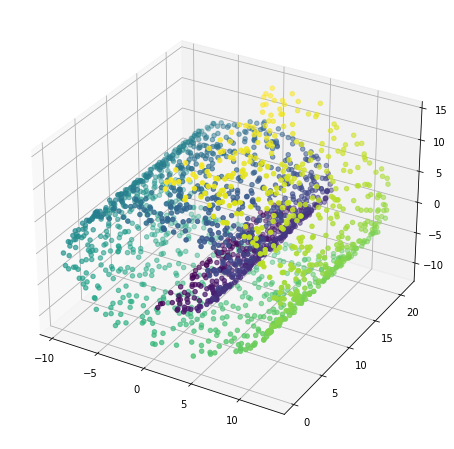

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
# Create Swiss roll data
X, y = make_swiss_roll(n_samples=2000, noise=0.1)
# Reorder data by manifold label y
X = X[np.argsort(y),:]
y = np.sort(y)
# Plot Swiss roll data
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=y)
plt.show();

In [105]:
Dists = distance_matrix(X)
W = adaptive_anisotropic_kernel(Dists, k= 10, alpha = 0.7)
P_symmetric, D = diffusion_matrix(W, symmetric=True, return_degree=True)

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


In [106]:
diff_map = diffusion_coordinates(P_symmetric, D)

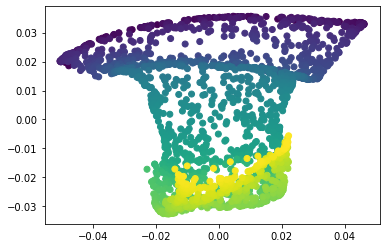

In [107]:
plt.scatter(diff_map[0],diff_map[1], c=y)

In [108]:
diff_map

array([[-0.01562173+0.j, -0.04691713+0.j,  0.03817015+0.j, ...,
         0.02141347+0.j,  0.02216555+0.j,  0.02170116+0.j],
       [ 0.03332453+0.j,  0.02166527+0.j,  0.03367546+0.j, ...,
        -0.0081516 +0.j, -0.00563511+0.j, -0.00769741+0.j],
       [-0.0335832 +0.j, -0.02795388+0.j, -0.03181012+0.j, ...,
         0.03200358+0.j,  0.03119533+0.j,  0.03187401+0.j],
       [-0.01586449+0.j, -0.01328833+0.j, -0.01582456+0.j, ...,
        -0.01653656+0.j, -0.01448934+0.j, -0.01620107+0.j],
       [ 0.02236068+0.j,  0.02236068+0.j,  0.02236068+0.j, ...,
         0.02236068+0.j,  0.02236068+0.j,  0.02236068+0.j]])

We have two free parameters here: k, the number of neighbors to consider, and alpha, the degree to which we renormalize by density.

 We can also achieve good results without the adaptive kernel, though this requires manually tuning `sigma` to give the kernel a bandwidth of around 4 on each side. Using nonzero anisotropy helps prevent the tightly rolled middle section of the swiss roll from being bunched together. $\alpha = 1$ seems to overcorrect, but $\alpha = 0.5$ is a nice sweet spot.

 Foregoing the adaptive kernel also combats the extreme density warping it creates, suggesting that the non-adaptive kernel is, in this instance, better suited to the task.

In [109]:
sigma = 2.23
alpha = 0.3
Dists = distance_matrix(X)
W = anisotropic_kernel(Dists, sigma=sigma, alpha = alpha)
P_symmetric, D = diffusion_matrix(W, symmetric=True, return_degree=True)
diff_map = diffusion_coordinates(P_symmetric, D)

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


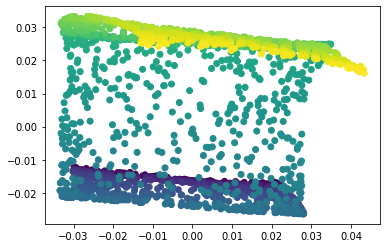

In [110]:
plt.scatter(diff_map[0],diff_map[1], c=y)

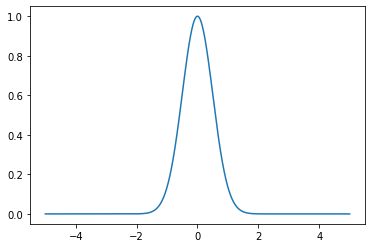

In [111]:
x_kernel = np.linspace(-5,5,1000)
y_kernel = np.exp(-x_kernel**2/(2*0.5**2))
plt.plot(x_kernel,y_kernel)

Let's wrap this all together into a function that produces a diffusion map from points, and even estimates the right sigma value for the kernel based on the median distance to near neighbors.

In [112]:
np.median(np.partition(Dists,10)[:,10])

1.7244400557286605

In [113]:
#export
import logging
def diffusion_map_from_points(X, t = 1, kernel_type = "anisotropic", alpha = 0.5, sigma = "automatic", k = 10):
  """Creates diffusion map from data matrix X, using specified kernel.

  Parameters
  ----------
  X : ndarray, possibly sparse
      data matrix
  t : int
      steps of diffusion to take.
  kernel_type : "adaptive" or "adaptive anisotropic", optional
      Type of kernel to use, by default "anisotropic"
  alpha : float, optional
      Density normalization, between 0 and 1, by default 0.5
  sigma : float, optional
      kernel bandwidth, by default "automatic"
  k : int, optional
      nearest neighbor number to use when estimating kernel bandwidth, by default 10

  Returns
  -------
  ndarray
      new coordinates of the data in diffusion space, as the rows of this matrix, ordered by the importance of the eigenvalue
  """
  Dists = distance_matrix(X)
  if sigma == "automatic":
    # Heuristic for sigma: median of the distance to the kth nearest neighbor
    sigma = np.median(np.partition(Dists,k)[:,k])
    print("using sigma = ",sigma)
  W = anisotropic_kernel(Dists, sigma=sigma, alpha = alpha)
  P_symmetric, D = diffusion_matrix(W, symmetric=True, return_degree=True)
  diff_map = diffusion_coordinates(P_symmetric, D, t = t)
  return diff_map

Double checking that my numpy trick to reverse the columns' order works

In [114]:
U = np.array([[1,2,3],[4,5,6],[7,8,9]])
U

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [115]:
U[:,::-1].T

array([[3, 6, 9],
       [2, 5, 8],
       [1, 4, 7]])

And, let's test whether this diffusion map method works:

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


using sigma =  2.4907641044602737


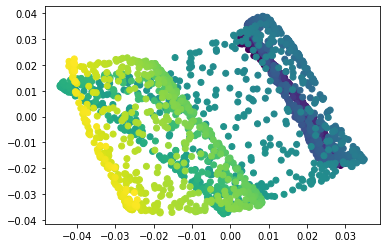

In [116]:
diff_map = diffusion_map_from_points(X,k=20)
plt.scatter(diff_map[0],diff_map[1],c=y)

In [117]:
#export
# For plotting 2D and 3D graphs
import plotly
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_3d(X,distribution=None, title="",lim=None,use_plotly=False,colorbar = False, cmap="plasma"):
    if distribution is None:
        distribution = np.zeros(len(X))
    if lim is None:
        lim = np.max(np.linalg.norm(X,axis=1))
    if use_plotly:
        d = {'x':X[:,0],'y':X[:,1],'z':X[:,2],'colors':distribution}
        df = pd.DataFrame(data=d)
        fig = px.scatter_3d(df, x='x',y='y',z='z',color='colors', title=title, range_x=[-lim,lim], range_y=[-lim,lim],range_z=[-lim,lim])
        fig.show()
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        ax.axes.set_xlim3d(left=-lim, right=lim)
        ax.axes.set_ylim3d(bottom=-lim, top=lim)
        ax.axes.set_zlim3d(bottom=-lim, top=lim)
        im = ax.scatter(X[:,0],X[:,1],X[:,2],c=distribution,cmap=cmap)
        ax.set_title(title)
        if colorbar: fig.colorbar(im, ax=ax)
        plt.show()


# Testing an another Swiss Roll
The code is resurrected in 05c05b as a testing ground for the flow learning. Here's an attempt to figure out the right parameters to get a good diffusion map:

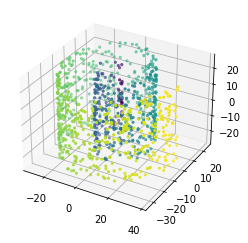

In [162]:
from directed_graphs.datasets import directed_swiss_roll_uniform, plot_directed_3d, affinity_grid_search
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2, radius=3, height=50, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

/tmp/ipykernel_186322/1105853613.py:6: UserWarning: Sparsifying input to bsr_array
  warnings.warn("Sparsifying input to bsr_array")


using sigma =  6.2625906376906295


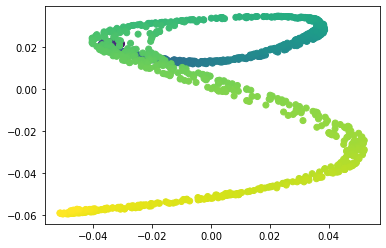

In [171]:
diff_map = diffusion_map_from_points(X,k=10)
plt.scatter(diff_map[0],diff_map[3],c=labels)